In [1]:
# стандартные
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# препроцессинг и метрики
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# keras
from keras.models import Sequential
from keras.layers import Dense, Bidirectional
from keras.layers import LSTM
from keras.layers import Dropout

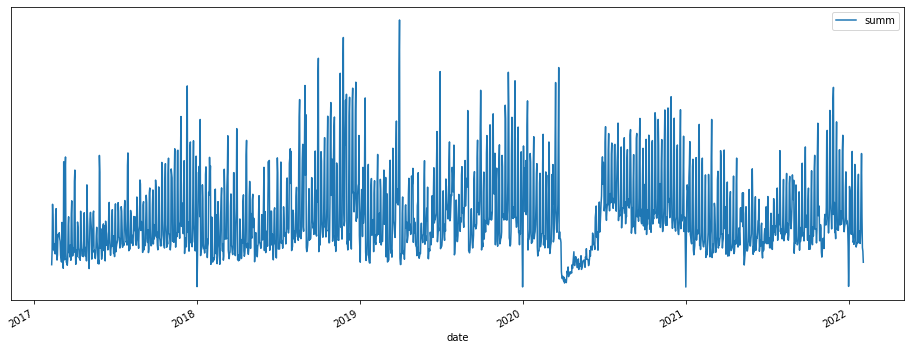

In [2]:
# загружаю данные по продажам
df_CD = pd.read_csv('./data/new_days.csv', header = None, sep = ';', skiprows = 520, names = ['date', 'summ'])
# привожу данные к нужным типам
df_CD['date'] = pd.to_datetime(df_CD['date'], format = "%d.%m.%Y")
df_CD['summ'] = df_CD['summ'].astype('float64')
# установим дату в качестве индекса
df_CD = df_CD.set_index('date')
# рисуем
df_CD.plot(figsize=(16, 6), yticks=[])
plt.show()

In [3]:
# первые 520 записей пропущены, т.к. там откровенный мусор
# имеем массив данных "дата"-"сумма" (с 9/02/2017 по 3/02/2022, суммы "по заказам" из 1С)

In [4]:
# найдем пропущенные даты и присвоим меткам среднее значение по всему временному ряду

In [5]:
# генерим полный набор от стартовой до конечной даты исходного временного ряда, без пропусков, частота=день
timerange = pd.date_range(start = df_CD.index[0], end = df_CD.index[-1], freq = 'D')
# генерим датасет
df2 = pd.DataFrame(index = timerange)
# джойним исходный временной ряд с синтетическим
# там, где в исходном ряду пропущены даты, получим пропущенную дату и NaN в столбце "summ"
newdf = df_CD.join(df2, how = 'outer')
print(f'Было пропущено дней: {newdf.shape[0] - df_CD.shape[0]}')

Было пропущено дней: 1


In [6]:
# заменяем все NaN на среднее значение по всему временному ряду
df_CD = newdf.fillna(newdf['summ'].mean())
df_CD.shape

(1821, 1)

In [7]:
# получили набор данных
df_CD.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1821 entries, 2017-02-09 to 2022-02-03
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   summ    1821 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB


In [8]:
#df_CD.head()

In [9]:
# вспомогательные функции
def days_weeks_months(df, period = 'day'):
    """ 
        Возвращает ряд значений после ресэмплинга исходного временного ряда.
        Отрисовывает полученный ряд значений.
        Параментры: df - исходный временной ряд, 
                    period - параметр группировки (day, week, month).
    """
    # если нужны недели или месяцы
    if period != 'day':
        ts = df['summ'].resample(period[0]).mean()
    # если нужны дни
    else:
        ts = df['summ']
    # рисуем
    plt.figure(figsize=(16, 2))
    plt.title(f'Ряд значений - {period}')
    plt.plot(ts.values)
    plt.yticks([])
    plt.show()
    # возвращаем ряд значений
    return ts.values

def ts_feature_preparation(ts, window, n_predictions):
    """ 
        Преобразует ряд значений в фичи и метки для нейронной сети.
        Возвращает фичи и метки.
        Параментры: ts - ряд значений,
                    window - глубина анализа ряда значений, 
                    n_predictions - глубина предсказания.
    """
    # нормализуем данные
    scaler = MinMaxScaler(feature_range = (0, 1))
    ts_training_scaled = scaler.fit_transform(ts.reshape(-1,1)[:-n_predictions])
    # выделяем фичи и метки
    features_set = []
    labels = []
    for i in range(window, ts_training_scaled.shape[0]):
        features_set.append(ts_training_scaled[i-window:i, 0])
        labels.append(ts_training_scaled[i, 0])
    # преобразуем фичи и метки в массивы numpy
    features_set, labels = np.array(features_set), np.array(labels)
    # преобразуем фичи в в формат для работы с нейронной сетью
    features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
    # печатаем размерности массивов
    print(f'Размерность: фичи - {features_set.shape}, метки - {labels.shape}')
    # возвращаем фичи и метки
    return features_set, labels, scaler

def lstm_model(units, input_shape, summary = False):
    """ 
        Собирает и возвращает модель.
        Параментры: units - количество нейронов входного слоя,
                    input_shape - размерность данных (features_set.shape[1], 1), 
                    summary - смотрим ли на модель.
    """
    # конфигурация нейронной сети
    model = Sequential()
    # LSTM
    model.add(Bidirectional(LSTM(units = units, return_sequences = False), input_shape = input_shape))
    model.add(Dropout(0.2))
    # полносвязные слои
    model.add(Dense(units = 1000))
    model.add(Dropout(0.2))
    model.add(Dense(units = 100))
    model.add(Dropout(0.2))
    model.add(Dense(units = 30))
    model.add(Dropout(0.1))
    # выходной слой
    model.add(Dense(units = 1))
    # собираем модель
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    # смотрим на модель
    if summary:
        print(model.summary())
    # возвращаем модель
    return model

def model_fit(model, features_set, labels, epochs, batch_size = 16, validation_split = .1, verbose = 2):
    """ 
        Тренирует модель.
        Возвращает модель и объект history.
        Параментры: model - модель,
                    features_set - фичи,
                    labels - метки,
                    epochs - количество эпох,
                    batch_size - размер батча,
                    validation_split - размер набора валидации,
                    verbose - степень детализации процесса обучения.
    """
    hist = model.fit(features_set, labels, epochs = epochs, batch_size = batch_size, \
                     validation_split = validation_split, verbose = verbose)
    # возвращаем
    return model, hist
           

def pict_loss_val_loss(history):
    """ 
        Рисуем графики loss и val_loss.
        Параметры: history - объект history.
    """
    plt.figure(figsize=(16, 4))
    plt.plot(history.history['loss'], color = 'blue')
    plt.plot(history.history['val_loss'], color = 'orange')
    plt.show()
    
def test_feature_preparation(ts, window, n_predictions, scaler):
    """ 
        Преобразует ряд значений в фичи для нейронной сети и метки для оценки качества.
        Возвращает фичи и метки.
        Параментры: ts - ряд значений,
                    window - глубина анализа ряда значений, 
                    n_predictions - глубина предсказания,
                    scaler - обученный нормализатор.
    """
    ts_testing_processed = ts[len(ts) - n_predictions:]
    test_inputs = ts[len(ts) - len(ts_testing_processed) - window:]
    test_inputs = test_inputs.reshape(-1, 1)
    test_inputs = scaler.transform(test_inputs)
    
    test_features = []
    test_labels = []
    for i in range(window, window + ts_testing_processed.shape[0]):
        test_features.append(test_inputs[i - window:i, 0])
        test_labels.append(test_inputs[i, 0])
    
    test_features = np.array(test_features)
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
    
    print(f'Размерность: фичи - {test_features.shape}, метки - {len(test_labels)}')
    
    # возвращаем фичи и метки
    return test_features, test_labels

def test_predict(model, test_features, scaler):
    """ 
        Предсказывает.
        Возвращает предсказание.
        Параментры: model - обученная модель,
                    test_features - фичи для предсказания,
                    scaler - обученный нормализатор.
    """
    return model.predict(test_features)

def pict_predict(predictions, test_labels, scaler):
    """ 
        Печатает графики предсказанных и истинных значений, печатает ошибки.
        Параментры: predictions - предсказанные значения,
                    test_labels - истинные значения,
                    scaler - обученный нормализатор.
    """
    # денормализация
    rescaled_predictions = scaler.inverse_transform(predictions)
    rescaled_labels = scaler.inverse_transform(np.array(test_labels).reshape(-1, 1))
    # рисуем
    plt.figure(figsize=(16,4))
    plt.plot(rescaled_labels[:], color='blue', label='истинные значения')
    plt.plot(rescaled_predictions[:], color='red', label='предсказанные значения')
    plt.title('Предсказание оборота')
    plt.xlabel('Дата')
    plt.ylabel('Оборот')
    plt.yticks([])
    plt.legend()
    plt.show()
    # печатаем ошибки
    #отклонение в шкале нормализованных значений данных
    print(f'sqrt(MSE) на норм. данных: {np.sqrt(mean_squared_error(test_labels[:], predictions[:]))}')
    #отклонение в шкале реальных значений данных
    #print(f'sqrt(MSE) на реальных данных: {np.sqrt(mean_squared_error(rescaled_labels[:], rescaled_predictions[:]))}')

In [10]:
# цель - предсказать объем продаж на период

In [11]:
# 1-я попытка: берем исходный временной ряд "по дням", учим нейронную сеть, проверяем

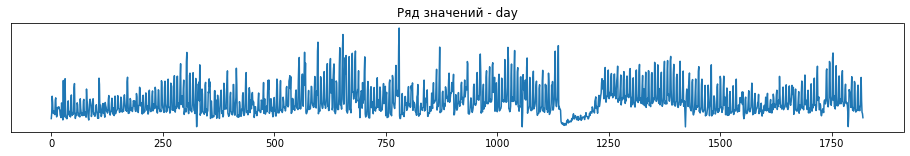

In [12]:
window = 180
n_predictions = 90
ts = days_weeks_months(df_CD, period = 'day')

In [13]:
features, labels, scaler = ts_feature_preparation(ts, window = window, n_predictions = n_predictions)

Размерность: фичи - (1551, 180, 1), метки - (1551,)


In [14]:
%%time
model, hist = model_fit(lstm_model(window, (features.shape[1], 1), summary = False), \
                        features, labels, epochs = 50, batch_size = 16, validation_split = .1, verbose = 0)

Metal device set to: Apple M1


2022-02-20 10:51:58.371656: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-20 10:51:58.371789: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-02-20 10:51:58.595417: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-20 10:51:59.273501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 10:51:59.490987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 10:51:59.502692: I tensorflow/core/grappler/o

CPU times: user 6min 8s, sys: 1min 11s, total: 7min 19s
Wall time: 6min 17s


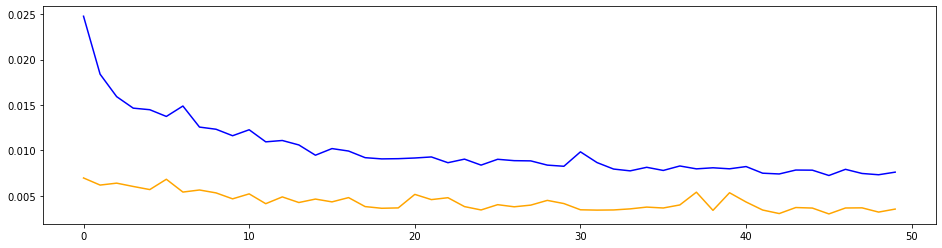

In [15]:
pict_loss_val_loss(hist)

In [16]:
test_features, test_labels = test_feature_preparation(ts, window, n_predictions, scaler)

Размерность: фичи - (90, 180, 1), метки - 90


In [17]:
predictions = test_predict(model, test_features, scaler)

2022-02-20 10:58:16.390325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 10:58:16.458086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 10:58:16.465715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


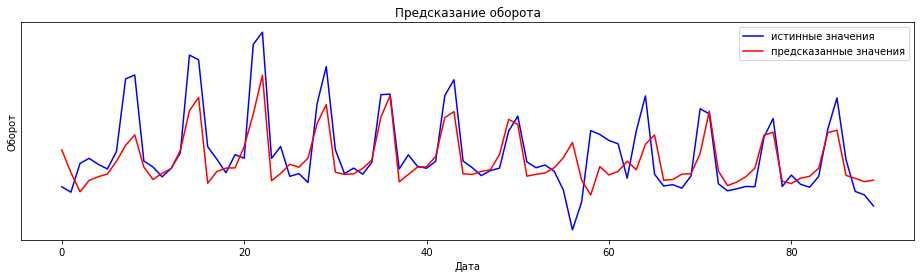

sqrt(MSE) на норм. данных: 0.09757317569376134


In [18]:
pict_predict(predictions, test_labels, scaler)

In [19]:
# 2-я попытка: берем исходный временной ряд "по неделям", учим нейронную сеть, проверяем

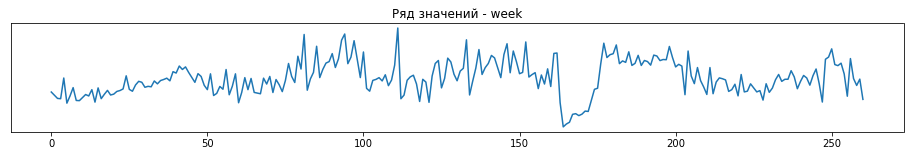

In [20]:
window = 52
n_predictions = 12
ts = days_weeks_months(df_CD, period = 'week')

In [21]:
features, labels, scaler = ts_feature_preparation(ts, window = window, n_predictions = n_predictions)

Размерность: фичи - (197, 52, 1), метки - (197,)


In [22]:
%%time
model, hist = model_fit(lstm_model(window, (features.shape[1], 1), summary = False), \
                        features, labels, epochs = 50, batch_size = 16, validation_split = .1, verbose = 0)

2022-02-20 10:58:18.074123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 10:58:18.295735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 10:58:18.307130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 10:58:18.430179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 10:58:18.444593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 10:58:19.331843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 10:58:19.407384: I tensorflow/core/grappler/optimizers/cust

CPU times: user 22.1 s, sys: 5.99 s, total: 28 s
Wall time: 21.9 s


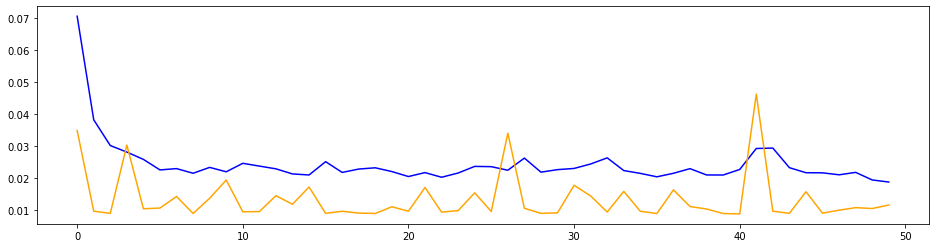

In [23]:
pict_loss_val_loss(hist)

In [24]:
test_features, test_labels = test_feature_preparation(ts, window, n_predictions, scaler)

Размерность: фичи - (12, 52, 1), метки - 12


In [25]:
predictions = test_predict(model, test_features, scaler)

2022-02-20 10:58:39.378961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 10:58:39.451895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 10:58:39.460063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


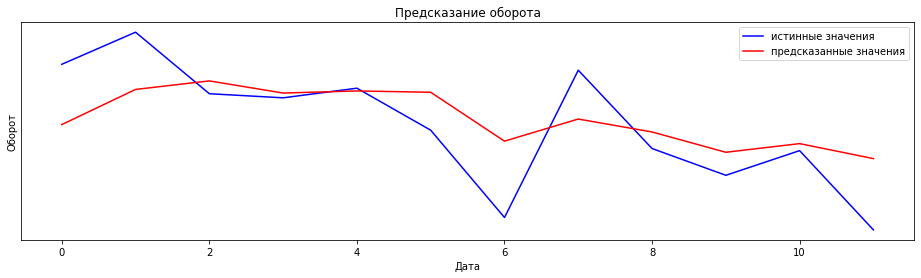

sqrt(MSE) на норм. данных: 0.11243533684924678


In [26]:
pict_predict(predictions, test_labels, scaler)

In [27]:
# 3-я попытка: берем исходный временной ряд "по месяцам", учим нейронную сеть, проверяем

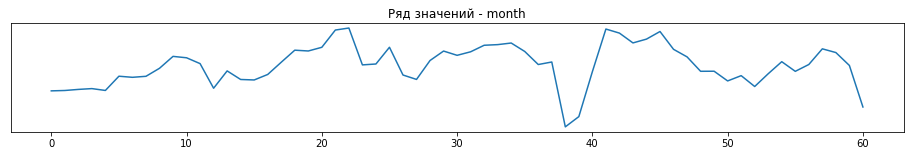

In [28]:
window = 12
n_predictions = 12
ts = days_weeks_months(df_CD, period = 'month')

In [29]:
features, labels, scaler = ts_feature_preparation(ts, window = window, n_predictions = n_predictions)

Размерность: фичи - (37, 12, 1), метки - (37,)


In [30]:
%%time
model, hist = model_fit(lstm_model(window, (features.shape[1], 1), summary = False), \
                 features, labels, epochs = 100, batch_size = 16, validation_split = .1, verbose = 0)

2022-02-20 10:58:40.606523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 10:58:40.835741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 10:58:40.846715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 10:58:40.927840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 10:58:40.942342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 10:58:41.273799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 10:58:41.350341: I tensorflow/core/grappler/optimizers/cust

CPU times: user 7.53 s, sys: 1.92 s, total: 9.45 s
Wall time: 7.7 s


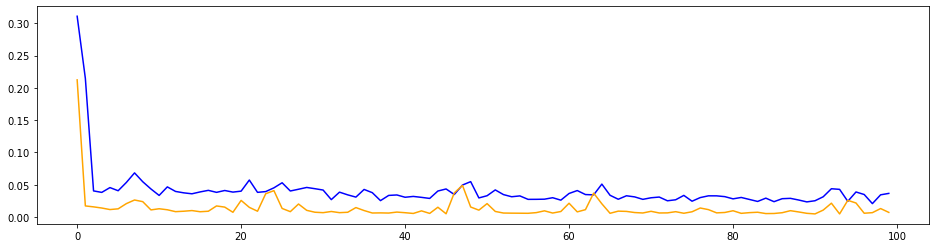

In [31]:
pict_loss_val_loss(hist)

In [32]:
test_features, test_labels = test_feature_preparation(ts, window, n_predictions, scaler)

Размерность: фичи - (12, 12, 1), метки - 12


In [33]:
predictions = test_predict(model, test_features, scaler)

2022-02-20 10:58:47.548481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 10:58:47.619353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-20 10:58:47.627217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


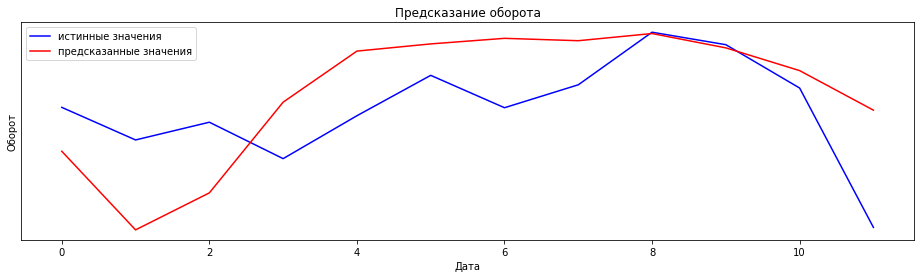

sqrt(MSE) на норм. данных: 0.18294828576554342


In [34]:
pict_predict(predictions, test_labels, scaler)